<div style="text-align: center; margin-left: px;">
    <h1 style="color: orange;">Jurassic World Reviews Sentiment Analysis</h1>
</div>

<div style="text-align: center; margin-left: px;">
    <h1 style="color: teal;">Overview</h1>
</div>

Did Sentiment Analysis of Jurassic World Dominion which was recently released on netflix and orignal release year is 2022.
Scraped the reviews by using libraries and plugins. 

Tools Used = 
1. for scraping data              - Used selenium librery to scrap imbd movie reviews.
                     - Used Plugin for Rotten Tomatoes movie review data.
             
2. Preprocessing     - Used nltk library for preprocessing the text of the reviews
             
3. Sentiment Analysis- Used VADER (Valence Aware Dictionary and Entiment Reasoner) for sentiment analysis.

<div style="text-align: center; margin-left: px;">
    <h1 style="color: red;">Importing Libraries</h1>
</div>

In [44]:
import numpy as np
import pandas as pd
import selenium
from scrapy.selector import Selector
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from selenium.webdriver.chrome.service import Service
import re
import nltk                                
from nltk.corpus import twitter_samples    
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from nltk.stem import PorterStemmer        
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer   
import string
import emoji
import demoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

<div style="text-align: center; margin-left: px;">
    <h1 style="color: red">Functions Used in notebook</h1>
</div>

In [2]:
nltk.download("stopwords")
stopwords_english = stopwords.words('english')
def remove_punc(sen): # function used to tokenize the reviews and removing puctuation and stopwoeds
    try:
        token = word_tokenize(sen)
        tweets_clean = []
        for word in token: # Go through every word in your tokens list
            if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
                tweets_clean.append(word)
        return tweets_clean
    except:
        return np.nan

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def process_tweet(tweet): #for preprocessing twitter reviews
    tweet= demoji.replace(tweet,'')  #removing the emojis
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    try:   
        sentiment = analyzer.polarity_scores(text)
        if sentiment['compound'] >= 0.05:
            return 'positive'
        elif sentiment['compound'] <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    except:
        return np.nan


In [230]:
# Check setiment distribution of reviews 
def pie_chart(dataframe):
  # Converting pd object to list of string
  label_types  = ['positive','negative','neutral']
  # Count tweets for each label
  label_counts = dataframe.sentiment.value_counts()     
  print('Labels in the dataset: ', label_types) 
  print(label_counts)
  # labels for the two classes
  labels = label_types #'Positives', 'Negative'
  # Sizes for each slide
  sizes = [count for count in label_counts]
  # Declare a figure with a custom size
  fig = plt.figure(figsize=(5, 5))
  # Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
  plt.pie(sizes, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.axis('equal') 
  # Display the chart
  plt.show()

In [ ]:
def filter_(list_):
    try:
        p = 'enjoyed'
        if p in list_ and len(list_)<15:
            return True
        else:
            return False
    except:
        return False

<div style="text-align: center; margin-left: px;">
    <h1 style="color:red;">Web Scraping IMBD Reviews</h1>
</div>

In [5]:
df_tweets = pd.read_csv("tweets.csv")  

In [7]:
df_imbd = pd.read_csv("imbd_reviews.csv")

In [76]:
df_twitter = df_tweets['text']

In [6]:
df_rt = pd.read_csv("rotentomatoes.csv")

In [8]:
df_rt.drop(df_rt.columns[[0,1,4]],axis = 1,inplace = True)

In [49]:
df_rt

,audience-reviews__duration,audience-reviews__review
0,"Oct 12, 2023","the worst jurassic park movies, there's nothin..."
1,"Oct 9, 2023",The start of the movie was a bit slow but then...
2,"Oct 5, 2023",Wow \nWhat a colossal waist of time and money ...
3,"Oct 3, 2023",Just the nostalgia makes it such a great movie...
4,"Oct 1, 2023",I loved it! I really think people can't just w...
...,...,...
6315,"Jun 15, 2022",Starts out slow. Too much talking. Once the di...
6316,"Jun 15, 2022",Dinosaurs were cool but the story was a bit la...
6317,"Jun 15, 2022","While it was a big budget spectacle, the overw..."
6318,"Jun 15, 2022",Great storyline and cinematography. Love the ...


In [85]:
s = Service("chromedriver.exe")
driver = webdriver.Chrome(service = s)
url = "https://www.imdb.com/title/tt8041270/reviews/?ref_=tt_ov_rt"
driver.get(url)

In [64]:
sel = Selector(text = driver.page_source)
review_counts = sel.css('.lister .header span::text').extract_first().replace(',','').split(' ')[0]
more_review_pages = int(int(review_counts)/25)

In [87]:
for i in tqdm(range(more_review_pages)):
    try:
        css_selector = 'load-more-trigger'
        driver.find_element(By.ID, css_selector).click()
        time.sleep(2)
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [00:06<00:00, 15.64it/s]


In [88]:
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

In [89]:
sel2 = Selector(text = reviews[3].get_attribute('innerHTML'))

In [90]:
review = sel2.css('.text.show-more__control::text').extract_first().strip()

In [91]:
rating_list = []
review_date_list = []
review_title_list = []
author_list = []
review_list = []
review_url_list = []
error_url_list = []
error_msg_list = []
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

for d in tqdm(reviews):
    try:
        sel2 = Selector(text = d.get_attribute('innerHTML'))
        try:
            rating = sel2.css('.rating-other-user-rating span::text').extract_first()
        except:
            rating = np.NaN
        try:
            review = sel2.css('.text.show-more__control::text').extract_first()
        except:
            review = np.NaN
        try:
            review_date = sel2.css('.review-date::text').extract_first()
        except:
            review_date = np.NaN    
        try:
            author = sel2.css('.display-name-link a::text').extract_first()
        except:
            author = np.NaN    
        try:
            review_title = sel2.css('a.title::text').extract_first()
        except:
            review_title = np.NaN
        try:
            review_url = sel2.css('a.title::attr(href)').extract_first()
        except:
            review_url = np.NaN
        rating_list.append(rating)
        review_date_list.append(review_date)
        review_title_list.append(review_title)
        author_list.append(author)
        review_list.append(review)
        review_url_list.append(review_url)
    except Exception as e:
        error_url_list.append(url)
        error_msg_list.append(e)
review_df = pd.DataFrame({
    'Review_Date':review_date_list,
    'Author':author_list,
    'Rating':rating_list,
    'Review_Title':review_title_list,
    'Review':review_list,
    'Review_Url':review_url
    })

100%|██████████████████████████████████████████████████████████████████████████████| 2732/2732 [01:00<00:00, 45.28it/s]


In [92]:
review_df

,Review_Date,Author,Rating,Review_Title,Review,Review_Url
0,23 July 2022,stevelivesey67,2,"Astonishingly bad, long and boring\n","Bad script, bad acting, stupid story, a new di...",/review/rw8229952/?ref_=tt_urv
1,5 June 2022,sumtim3s00n,None,"80% revisiting old characters and scenes, no ...",This movie consists mostly of us watching prev...,/review/rw8229952/?ref_=tt_urv
2,10 June 2022,FeastMode,3,"A generic, lifeless adventure movie that happ...",If I were to list out all the things this movi...,/review/rw8229952/?ref_=tt_urv
3,23 June 2022,Hitchcoc,5,Sorry It Was So Bad\n,Before I went to this film (because my Grandso...,/review/rw8229952/?ref_=tt_urv
4,16 June 2022,bass-player-blues,1,Things I learned from Jurassic World: Dominio...,-Dinousaurs that only survived in warm climate...,/review/rw8229952/?ref_=tt_urv
...,...,...,...,...,...,...
2727,26 November 2022,jameslau-54307,2,Ruining my childhood memories.\n,Please stop making more Jurassic World films. ...,/review/rw8229952/?ref_=tt_urv
2728,17 July 2022,bobbertv,None,Jeff Goldbloom owes me 20$ bucks!!!!!\n,First off whose this white haired Steve Jobs/ ...,/review/rw8229952/?ref_=tt_urv
2729,11 June 2022,MaxRockatansky99,5,Milking the franchise\n,"Visually beautiful, the CGI is excellent, and ...",/review/rw8229952/?ref_=tt_urv
2730,20 September 2022,ddrutis,3,You can only go there so many times - corny a...,I've enjoyed all of the Jurassic Park movies -...,/review/rw8229952/?ref_=tt_urv


In [94]:
review_df.to_csv("imbd_reviews.csv")

## Preprocessing text of Twitter Reviews

In [79]:
process_t_r= df_twitter.apply(process_tweet)

In [80]:
flattened_list = [item for sublist in list(process_t_r) for item in sublist]

In [82]:
tweet_word_series= pd.Series(flattened_list)

In [83]:
p_w_t=[]
n_w_t=[]
ne_w_t=[]
for i in tweet_word_series:
    if i in negative_words:
        n_w_t.append(i)
    elif i in positive_words:
        p_w_t.append(i)
    else:
        ne_w_t.append(i)

In [78]:
df_twitter.apply(analyze_sentiment).value_counts()

positive    285
neutral     194
negative     45
Name: text, dtype: int64

## Preprocessing Imbd and Rotten Tomatoes Reviews

In [162]:
df_rt.columns

Index(['audience-reviews__duration', 'audience-reviews__review'], dtype='object')

In [11]:
df_rt.rename(columns = {'audience-reviews__duration':'Review_Date','audience-reviews__review':'Review'},inplace = True)

In [9]:
df_imbd_reviews =  df_imbd[['Review_Date','Review']]

In [13]:
df_reviews =  pd.concat([df_imbd_reviews,df_rt],axis=0,ignore_index=True) #combining imbd and rotten tomatoes reviews

In [18]:
df_reviews['Review_Date']=pd.to_datetime(df_reviews['Review_Date'])

In [31]:
puc_removed=df_reviews['Review'].apply(remove_punc)

In [35]:
l_reviews_words= []
for i in puc_removed:
    try:
        l_reviews_words.extend(i)
    except:
        print(i)

nan


In [214]:
review_word_series= pd.Series(l_reviews_words)

## Analyzing Reviews Using Positive and negative Words

In [46]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [215]:
p_w=[]
n_w=[]
ne_w=[]
for i in review_word_series:
    if i in negative_words:
        n_w.append(i)
    elif i in positive_words:
        p_w.append(i)
    else:
        ne_w.append(i)

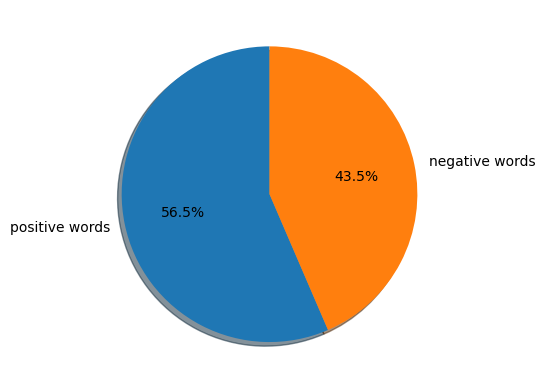

In [216]:
plt.pie(x = [len(p_w),len(n_w)],labels = ['positive words','negative words'],startangle=90,autopct='%1.1f%%',shadow= True)
plt.show()

Insight -There diff betwwen positive and negative worlds is not much which shows that movie was not much liked by the audiance.

In [102]:
df_reviews

,Review_Date,Review,sentiment
0,2022-07-23,"Bad script, bad acting, stupid story, a new di...",negative
1,2022-06-05,This movie consists mostly of us watching prev...,positive
2,2022-06-10,If I were to list out all the things this movi...,positive
3,2022-06-23,Before I went to this film (because my Grandso...,positive
4,2022-06-16,-Dinousaurs that only survived in warm climate...,positive
...,...,...,...
9047,2022-06-15,Starts out slow. Too much talking. Once the di...,positive
9048,2022-06-15,Dinosaurs were cool but the story was a bit la...,negative
9049,2022-06-15,"While it was a big budget spectacle, the overw...",negative
9050,2022-06-15,Great storyline and cinematography. Love the ...,positive


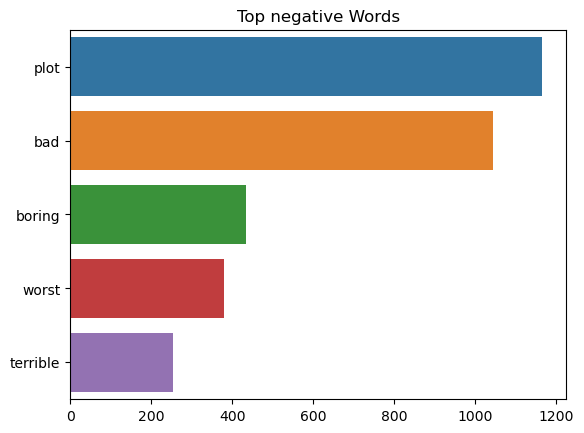

In [224]:
plt.title(label = "Top negative Words")
sns.barplot(y=pd.Series(n_w).value_counts()[0:5].index,x =pd.Series(n_w).value_counts()[0:5] )
plt.show()

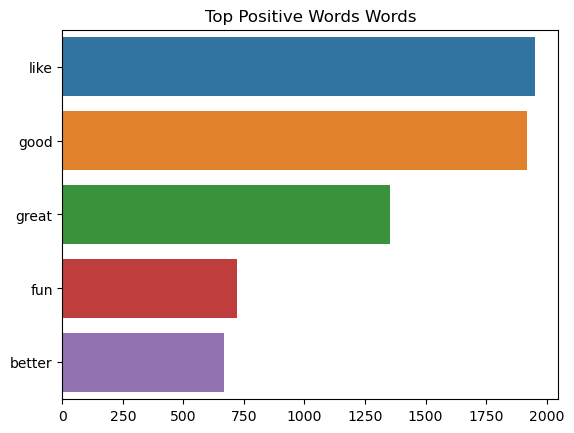

In [226]:
plt.title(label = "Top Positive Words")
sns.barplot(y=pd.Series(p_w).value_counts()[0:5].index,x =pd.Series(p_w).value_counts()[0:5] )
plt.show()

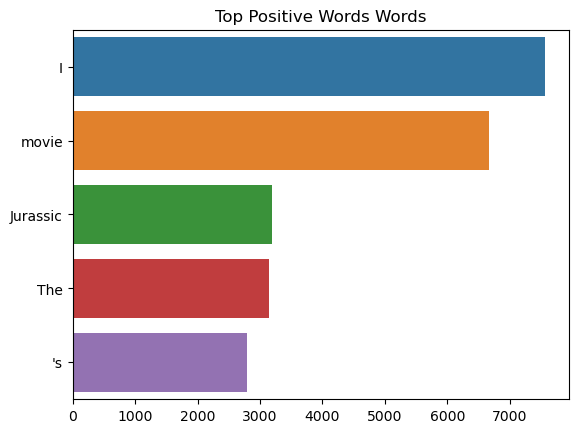

In [227]:
plt.title(label = "Top Positive Words ")
sns.barplot(y=pd.Series(ne_w).value_counts()[0:5].index,x =pd.Series(ne_w).value_counts()[0:5] )
plt.show()

## Analyzing Sentiment Analysis of reviews using VADER (Valence Aware Dictionary and Entiment Reasoner)

In [91]:
df_reviews['sentiment']= df_reviews['Review'].apply(analyze_sentiment)

In [92]:
df_reviews

,Review_Date,Review,sentiment
0,2022-07-23,"Bad script, bad acting, stupid story, a new di...",negative
1,2022-06-05,This movie consists mostly of us watching prev...,positive
2,2022-06-10,If I were to list out all the things this movi...,positive
3,2022-06-23,Before I went to this film (because my Grandso...,positive
4,2022-06-16,-Dinousaurs that only survived in warm climate...,positive
...,...,...,...
9047,2022-06-15,Starts out slow. Too much talking. Once the di...,positive
9048,2022-06-15,Dinosaurs were cool but the story was a bit la...,negative
9049,2022-06-15,"While it was a big budget spectacle, the overw...",negative
9050,2022-06-15,Great storyline and cinematography. Love the ...,positive


Labels in the dataset:  ['positive', 'negative', 'neutral']
positive    5863
negative    2499
neutral      689
Name: sentiment, dtype: int64


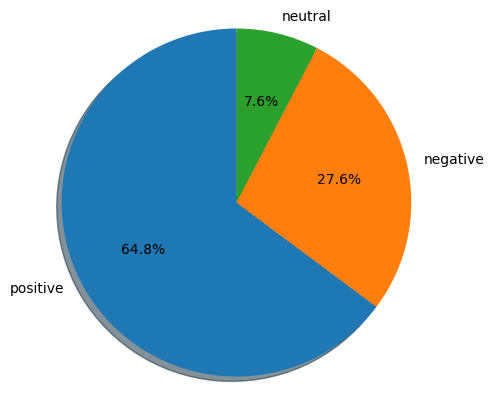

In [232]:
pie_chart(df_reviews)
plt.show()

In [119]:
df_reviews[['sentiment']].to_csv('review_sentiment.csv')

In [113]:
df_reviews.to_csv('df_reviews.csv')